In [12]:
# 필요한 모듈 불러오기
import imageio
import imgaug as ia
import numpy as np
import os
import json
from imgaug.augmentables.polys import Polygon, PolygonsOnImage
import imgaug.augmenters as iaa
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 절대경로 설정 (현재 ipynb파일이 있는 경로)
path_dir = os.path.abspath('.')
path_dir

'C:\\Users\\huijeong\\Desktop\\Data_Augmentation'

In [3]:
# images, flip_images폴더 경로 설정
path_images = os.path.join(path_dir, "example")
path_flip_images = os.path.join(path_dir, "rotate_images")

path_images, path_flip_images

('C:\\Users\\huijeong\\Desktop\\Data_Augmentation\\example',
 'C:\\Users\\huijeong\\Desktop\\Data_Augmentation\\rotate_images')

In [4]:
# json 파일 불러오기
with open(os.path.join(path_images, "via_region_data.json"), "r", encoding='utf-8') as f:
    content = json.load(f)

# print(content, sep='')
len(content)

2

In [5]:
# images폴더에 있는 파일 모두 보기
files = os.listdir(path_images)
len(files)

3

In [6]:
# 이미지(jpg, png, jpeg)만 보기
imgFiles = [_ for _ in files if _.split(".")[-1].lower() in ['jpg', 'png', 'jpeg']]
len(imgFiles)

2

In [56]:
# # 디버깅할 이미지만 보기
# imgFiles = [_ for _ in files if _.startswith('img2019-08-19_000')]
# len(imgFiles)

156

# 좌우반전

In [64]:
aug = iaa.Fliplr(1.0) # 100% Flip시켜주는 인스턴스
content_flip = copy.deepcopy(content) # Flip된 이미지의 json파일을 만들어주기 위해 기존 content를 복사합니다.

# 이미지 개수만큼 반복
for imgName in imgFiles:
    image = imageio.imread(os.path.join(path_images, imgName)) # 이미지
    imgSize = str(os.path.getsize(os.path.join(path_images, imgName))) # 파일 용량
    annotation = len(content_flip[imgName+imgSize]['regions']) # Annotation 개수
    
    # Annotation 개수만큼 반복
    for i in range(annotation):
        location = content_flip[imgName+imgSize]['regions'][str(i)]['shape_attributes'] # 기존 json파일에서 x, y좌표가 있는 경로
        x = location['all_points_x'] # x 좌표모음
        y = location['all_points_y'] # y 좌표모음
        point = [_ for _ in zip(x, y)] # (x, y)좌표모음
        point = Polygon(point) # (x, y)좌표를 Segmentation으로 만들기 위해 Polygon type으로 바꿔줍니다.
        # 원본 이미지와 크기가 같은 빈 이미지에 point만 찍어놓습니다. => Segmentation만 형성됩니다.
        segmentation = PolygonsOnImage([point], shape=image.shape)
        # 원본 이미지+Segmentation을 Flip합니다. => Flip된 이미지, Flip된 point(좌표)가 나옵니다.
        image_flip, point_flip = aug(image=image, polygons=segmentation)
        
        # Annotation 개수에 상관없이 1번만 실행되는 구문입니다.
        if i == 0:
            while True:
                try:
                    imageio.imwrite(os.path.join(path_flip_images, f'flip_{imgName}'), image_flip[:, :, :3]) # Flip된 이미지를 다운받습니다.
                except IndexError as e:
                    print(imgName, image_flip.shape, 'Shape가 2차원입니다.')
                    image_flip = np.expand_dims(image_flip, axis=2)
                    print('3차원으로 수정 후 저장합니다.', image_flip.shape)
                    continue
                break
                
            imgSize_flip = os.path.getsize(os.path.join(path_flip_images, f'flip_{imgName}')) # Flip된 이미지 파일 용량
        
        ################# content_flip의 x, y좌표를 바꿔줍니다. #################
        x_flip = point_flip.polygons[0].xx_int.tolist() # Flip된 point의 x좌표모음을 Polygon type에서 list type으로 바꿔줍니다.
        y_flip = point_flip.polygons[0].yy_int.tolist() # Flip된 point의 y좌표모음을 Polygon type에서 list type으로 바꿔줍니다.
        location['all_points_x'] = x_flip # Flip된 x좌표로 바꿔줍니다.
        location['all_points_y'] = y_flip # Flip된 y좌표로 바꿔줍니다.
        
    # 모든 Annotation의 좌표를 잘 바꿔줬다면 실행되는 구문입니다.
    else:
        ################# content_flip의 size, filename, key를 바꿔줍니다. #################
        content_flip[imgName+imgSize]['size'] = imgSize_flip # size를 바꿔줍니다. 
        content_flip[imgName+imgSize]['filename'] = f'flip_{imgName}' # filename을 바꿔줍니다.
        content_flip[f'flip_{imgName}{imgSize_flip}'] = content_flip.pop(imgName+imgSize) # key를 바꿔줍니다.

# 모든 이미지, Annotation이 Flip되어 저장되었고, Flip된 이미지를 반영하는 json파일(content_flip)이 완성되었습니다.
else:
    print("Happy New Year!") # 해피뉴이어!
    print('Flip된 이미지:', len(imgFiles), '중', len(os.listdir(path_flip_images))-1, '개')
        
# 수정이 완료된 content_flip을 기존 content와 합쳐줍니다.
content.update(content_flip)

# 합본 json파일을 저장합니다.
with open(os.path.join(path_flip_images, 'flip_via_region_data.json'), 'w', encoding='utf-8') as f:
    json.dump(content, f)

img2019-08-19_000339_페트병91.jpeg (600, 600) Shape가 2차원입니다.
3차원으로 수정 후 저장합니다. (600, 600, 1)
img2019-08-19_000739_페트병583.jpeg (600, 600) Shape가 2차원입니다.
3차원으로 수정 후 저장합니다. (600, 600, 1)
Happy New Year!
Flip된 이미지: 156 중 156 개


# 그레이스케일

In [101]:
# images, flip_images폴더 경로 설정
path_images = os.path.join(path_dir, "images")
path_flip_images = os.path.join(path_dir, "gray_images")

path_images, path_flip_images

('C:\\Users\\huijeong\\Desktop\\imgaug\\Flip_Augmentation\\images',
 'C:\\Users\\huijeong\\Desktop\\imgaug\\Flip_Augmentation\\gray_images')

In [102]:
# json 파일 불러오기
with open(os.path.join(path_images, "via_region_data.json"), "r", encoding='utf-8') as f:
    content = json.load(f)

# print(content, sep='')
len(content)

1261

In [103]:
# images폴더에 있는 파일 모두 보기
files = os.listdir(path_images)
len(files)

1262

In [104]:
# 이미지(jpg, png, jpeg)만 보기
imgFiles = [_ for _ in files if _.split(".")[-1].lower() in ['jpg', 'png', 'jpeg']]
len(imgFiles)

1261

In [111]:
from PIL import Image

aug = iaa.Grayscale(alpha=1) # 그레이스케일
content_flip = copy.deepcopy(content) # 그레이스케일된 이미지의 json파일을 만들어주기 위해 기존 content를 복사합니다.

# 이미지 개수만큼 반복
for imgName in imgFiles:
    image = imageio.imread(os.path.join(path_images, imgName))
    imgSize = str(os.path.getsize(os.path.join(path_images, imgName))) # 파일 용량
    
    if len(image.shape) < 3:
        image = np.expand_dims(image, axis=2)
        
    image_RGBA = Image.open(os.path.join(path_images, imgName))
    img = np.array(image_RGBA.convert('RGB'))
    
    image_aug = aug(image=img)    
    
    imageio.imwrite(os.path.join(path_flip_images, f'flip_{imgName}'), image_aug[:, :, :3])
    imgSize_flip = os.path.getsize(os.path.join(path_flip_images, f'flip_{imgName}')) # Flip된 이미지 파일 용량
    
    ################# content_flip의 size, filename, key를 바꿔줍니다. #################
    content_flip[imgName+imgSize]['size'] = imgSize_flip # size를 바꿔줍니다. 
    content_flip[imgName+imgSize]['filename'] = f'flip_{imgName}' # filename을 바꿔줍니다.
    content_flip[f'flip_{imgName}{imgSize_flip}'] = content_flip.pop(imgName+imgSize) # key를 바꿔줍니다.

content.update(content_flip)

with open(os.path.join(path_flip_images, 'flip_via_region_data.json'), 'w', encoding='utf-8') as f:
    json.dump(content, f)

# 회전

In [8]:
imgFiles

['fge4f43wtre4rtfewre.jpg', 'jasdf0934923jdzn1.jpg']

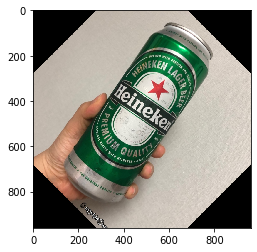

In [58]:
img = imageio.imread(os.path.join(path_images, imgFiles[0]))
# plt.imshow(img)

aug = iaa.geometric.Affine(rotate=45)
img = aug(image=img)

plt.imshow(img)

In [59]:
aug = iaa.geometric.Affine(rotate=45) # 그레이스케일
content_flip = copy.deepcopy(content) # 그레이스케일된 이미지의 json파일을 만들어주기 위해 기존 content를 복사합니다.

# 이미지 개수만큼 반복
for imgName in imgFiles:
    image = imageio.imread(os.path.join(path_images, imgName)) # 이미지
    imgSize = str(os.path.getsize(os.path.join(path_images, imgName))) # 파일 용량
    annotation = len(content_flip[imgName+imgSize]['regions']) # Annotation 개수
    
    # Annotation 개수만큼 반복
    for i in range(annotation):
        location = content_flip[imgName+imgSize]['regions'][str(i)]['shape_attributes'] # 기존 json파일에서 x, y좌표가 있는 경로
        x = location['all_points_x'] # x 좌표모음
        y = location['all_points_y'] # y 좌표모음
        point = [_ for _ in zip(x, y)] # (x, y)좌표모음
        point = Polygon(point) # (x, y)좌표를 Segmentation으로 만들기 위해 Polygon type으로 바꿔줍니다.
        # 원본 이미지와 크기가 같은 빈 이미지에 point만 찍어놓습니다. => Segmentation만 형성됩니다.
        segmentation = PolygonsOnImage([point], shape=image.shape)
        # 원본 이미지+Segmentation을 Flip합니다. => Flip된 이미지, Flip된 point(좌표)가 나옵니다.
        image_flip, point_flip = aug(image=image, polygons=segmentation)
        
        # Annotation 개수에 상관없이 1번만 실행되는 구문입니다.
        if i == 0:
            while True:
                try:
                    imageio.imwrite(os.path.join(path_flip_images, f'flip_{imgName}'), image_flip[:, :, :3]) # Flip된 이미지를 다운받습니다.
                except IndexError as e:
                    print(imgName, image_flip.shape, 'Shape가 2차원입니다.')
                    image_flip = np.expand_dims(image_flip, axis=2)
                    print('3차원으로 수정 후 저장합니다.', image_flip.shape)
                    continue
                break
                
            imgSize_flip = os.path.getsize(os.path.join(path_flip_images, f'flip_{imgName}')) # Flip된 이미지 파일 용량
        
        ################# content_flip의 x, y좌표를 바꿔줍니다. #################
        x_flip = point_flip.polygons[0].xx_int.tolist() # Flip된 point의 x좌표모음을 Polygon type에서 list type으로 바꿔줍니다.
        y_flip = point_flip.polygons[0].yy_int.tolist() # Flip된 point의 y좌표모음을 Polygon type에서 list type으로 바꿔줍니다.
        location['all_points_x'] = x_flip # Flip된 x좌표로 바꿔줍니다.
        location['all_points_y'] = y_flip # Flip된 y좌표로 바꿔줍니다.
        
    # 모든 Annotation의 좌표를 잘 바꿔줬다면 실행되는 구문입니다.
    else:
        ################# content_flip의 size, filename, key를 바꿔줍니다. #################
        content_flip[imgName+imgSize]['size'] = imgSize_flip # size를 바꿔줍니다. 
        content_flip[imgName+imgSize]['filename'] = f'flip_{imgName}' # filename을 바꿔줍니다.
        content_flip[f'flip_{imgName}{imgSize_flip}'] = content_flip.pop(imgName+imgSize) # key를 바꿔줍니다.

# 모든 이미지, Annotation이 Flip되어 저장되었고, Flip된 이미지를 반영하는 json파일(content_flip)이 완성되었습니다.
else:
    print("Happy New Year!") # 해피뉴이어!
    print('Flip된 이미지:', len(imgFiles), '중', len(os.listdir(path_flip_images))-1, '개')
        
# 수정이 완료된 content_flip을 기존 content와 합쳐줍니다.
content.update(content_flip)

# 합본 json파일을 저장합니다.
with open(os.path.join(path_flip_images, 'flip_via_region_data.json'), 'w', encoding='utf-8') as f:
    json.dump(content, f)

Happy New Year!
Flip된 이미지: 2 중 1 개
